# PyTCR - Example 2: Tropical cyclone rainfall generation

**Author:** [Phong Le](https://github.com/levuvietphong)

**Description:** This notebook demonstrates how to generate rainfall driven by tropical cyclones using track outputs from the statistical-dynamical [tropical cyclone downscaling model](https://github.com/linjonathan/tropical_cyclone_risk).

### Import libraries

In [175]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import colorcet as cc

import tcr.rainfall as tcr_rain
import tcr.wind as tcr_wind
import tcr.iodata as tcr_io
import tcr.convert as tcr_convert
import tcr.plots as tcr_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Configuration for Mapping and Plotting

In [176]:
# Mapping boundary and projection
xmin = -115; xmax = -45; dx = 10
ymin = 12; ymax = 48; dy = 10
extent = [xmin, xmax, ymin, ymax, dx, dy]
proj = ccrs.AzimuthalEquidistant(central_longitude=-80, central_latitude=30)

# Shapefile
fnCONUS = '../data/shapefiles/CONUS.shp'
shpCONUS = shpreader.Reader(fnCONUS)

# Plotting period
yearmin = 1964
yearmax = 2014
num_year = yearmax - yearmin + 1

# Directory containing the downscaled data
data_directory = '../data/downscaled/'

### Load data from a CMIP6 model
In this notebook, the [E3SM version 1.0](https://e3sm.org/) is demonstrated but the notebook is applicable to other [CMIP6 models](https://pcmdi.llnl.gov/CMIP6/).

In [177]:
model = 'E3SM-1-0'
expmnt='historical'

# Load NetCDF data
ds, lat_trks, lon_trks, n_trk, v_trks, vmax_trks, u850_trks, v850_trks, \
    tc_month, tc_years, tc_time = tcr_io.load_netcdf_track_data(
    data_directory=data_directory, model=model, basin='NA', expmnt=expmnt)

### Estimate the radius of the tropical cyclone based on circular wind speed.

In [178]:
# estimate_rm = True: will force to estimate the radius of maximum circular wind
# estimate_rm = False: will check if rm is already in the dataset.
#   - if yes, it skips this step
#   - if no, it will estimate rm. This step takes about 6 min for 1000 TCs.
# NOTE: After estimating rm, it will be saved in the netcdf file. Next time, it will skip this step.

estimate_rm = False

# force to estimate the radius of maximum circular wind
if 'rm_trks' not in list(ds.keys()) or estimate_rm == True:
    print('Estimating the radius of maximum circular wind... ')
    rm_trks = tcr_wind.estimate_radius_wind(
        ds, lat_trks, vmax_trks, n_trk, data_directory=data_directory, 
        model=model, basin='NA', expmnt=expmnt)
else:
    print('The radius of maximum circular wind was found in file!')
    print('Loading rm_trks...')
    rm_trks = ds['rm_trks'].values

The radius of maximum circular wind was found in file!
Loading rm_trks...


### Calculate accumulated rain and rainrates at specified locations for the active event set
- Currently, the TC downscaling model doesn't include any secondary eyewall effect.
- We temporarily set the secondary maximum wind speed and radius to zero

In [179]:
lat_poi = 29.5  # degree latitude
lon_poi = -95.4  # degree longitude

# Currently, no secondary rain bands
ut, vt, jmax = tcr_wind.utrans(lat_trks, lon_trks)

# Get datetime
date_trks = tcr_convert.to_datetime_from_netcdf(tc_years, tc_month, tc_time)

# Note: temporarily ignore secondary eyewalls
rain, rainrate, dayk = tcr_rain.raingen(lat_poi, lon_poi, lat_trks, lon_trks, date_trks, v_trks, rm_trks,
                                        0*v_trks, 0*rm_trks, u850_trks, v850_trks, ut, vt, T600=None)

#### Plot the accumulated rainfall over the hurricane period for the site POI (note that this includes storms that do not hit the POI area

Text(0.5, 1.0, 'Accumulated rainfall across all storm events for POI: (29.5$^\\circ$, -95.4$^\\circ$)')

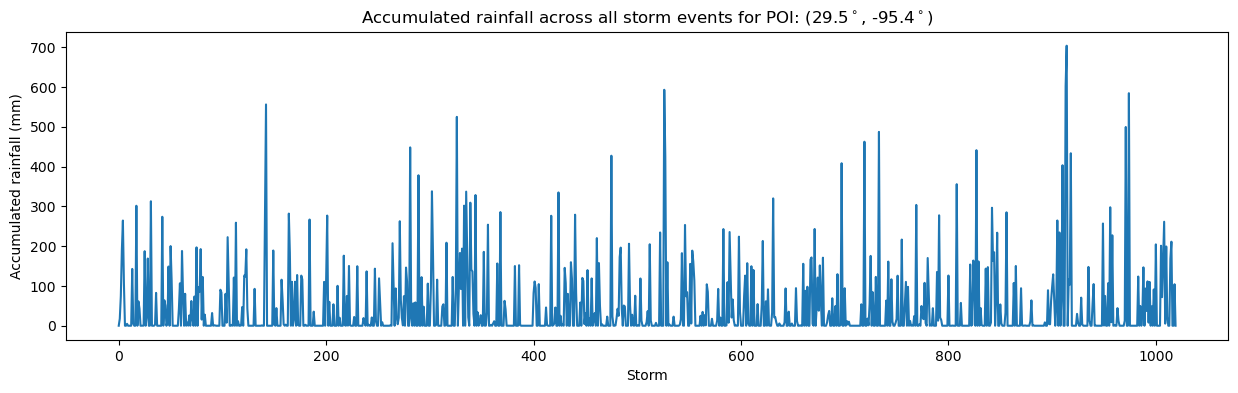

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(rain)
ax.set_ylabel('Accumulated rainfall (mm)')
ax.set_xlabel('Storm')
ax.set_title(
    f'Accumulated rainfall across all storm events for POI: ({lat_poi}$^\circ$, {lon_poi}$^\circ$)')

### Plot the rainfall rate time series for random storms

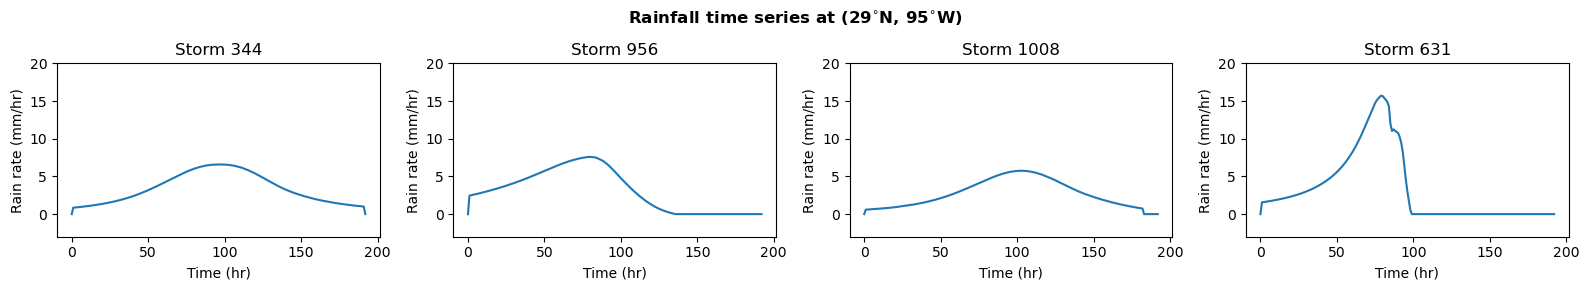

In [181]:
storms = np.where(rain>200)[0]
ind = np.random.choice(storms, 4, replace=False)
fig,ax = plt.subplots(1,4,figsize=(16,3))
for k in range(4):
    ax[k].plot(np.squeeze(rainrate[ind[k],:]))
    ax[k].set_xlabel('Time (hr)')
    ax[k].set_ylabel('Rain rate (mm/hr)')
    ax[k].set_title(f'Storm {ind[k]}')
    ax[k].set_ylim([-3, 20])
fig.suptitle('Rainfall time series at (29$^{\circ}$N, 95$^{\circ}$W)', fontsize=12, fontweight='bold', y=0.95)
fig.tight_layout()

### Calculate the spatial distribution of accumulated precipitation for a given individual storm.

In [182]:
# Select storm id
storm_id = 527
x, y, netrain = tcr_rain.rainswathx(storm_id, lat_trks, lon_trks, rm_trks, v_trks, 
                                    0*rm_trks, 0*v_trks, ut, vt, u850_trks, v850_trks)

### Plot of spatial accumulated precipitation

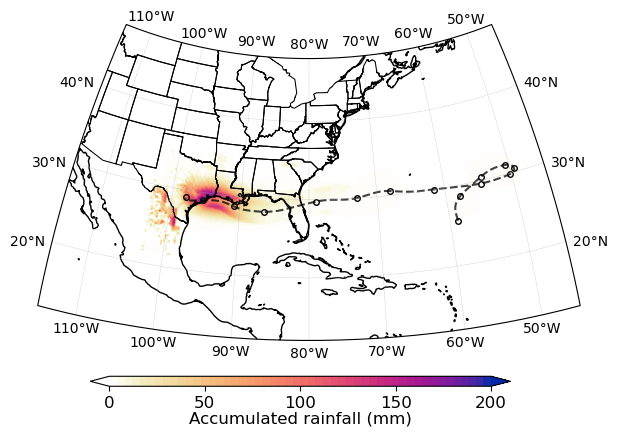

In [183]:
cmap = cc.cm.CET_L17
max_precip = 200
levels = np.linspace(0, max_precip, 51)
fig, ax = plt.subplots(1, 1, figsize=(7, 5), facecolor="w", subplot_kw=dict(projection=proj))

# PLOT Net Rainfall
im = tcr_plot.plot_density(ax, y, x, netrain, levels, extent=extent, alpha=1, cmap=cmap,
                           show_gridlabel=True, shapefile=shpCONUS)

ax.plot(lon_trks[storm_id, :], lat_trks[storm_id, :], color='k', ls='--',
        alpha=0.75, transform=ccrs.PlateCarree(), zorder=1)

# Show 15 dots along the track
ese = np.linspace(0, len(lon_trks[storm_id, :]) - 1, 15, dtype=int)
ax.plot(lon_trks[storm_id, ese], lat_trks[storm_id, ese], 'ok', ms=4,
        markerfacecolor='none', alpha=1, transform=ccrs.PlateCarree(), zorder=1)

# COLORBAR
cbax = fig.add_axes([0.2, 0.06, 0.6, 0.02])
cb = fig.colorbar(im, cax=cbax, orientation='horizontal')
cb.set_label(r'Accumulated rainfall (mm)', fontsize=12, labelpad=0)
cb.set_ticks(np.linspace(0, max_precip, 5))
cb.ax.tick_params(labelsize=12)

### Plot of spatial rainfall at a specific time step

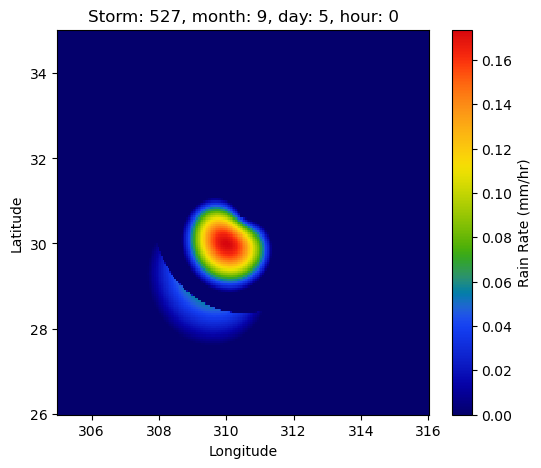

In [184]:
# Convert time to 2D arrays
num_storm = lat_trks.shape[0]
num_timestep = lat_trks.shape[1]

tc_month2d = np.tile(tc_month, (num_timestep, 1)).T
tc_hours2d = np.tile((tc_time / 3600) % 24, (num_storm, 1))
tc_days2d = np.tile(1+(tc_time / 3600) // 24, (num_storm, 1))

storm_id = 527
monthplot = int(tc_month[storm_id])
dayplot = 5 # 1-15
hourplot = 0 # 0-23
rainrate, longstorm, latstorm = tcr_rain.rainfieldx(
    storm_id, lat_trks, lon_trks, rm_trks, v_trks, 0*rm_trks,0*v_trks, ut, vt, u850_trks, 
    v850_trks, tc_month2d, tc_days2d, tc_hours2d, monthplot, dayplot, hourplot)

fig, ax = plt.subplots(1,1,figsize=(6,5))
im = ax.pcolor(longstorm, latstorm, rainrate, cmap=cc.cm.CET_R4)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Storm: {storm_id}, month: {monthplot}, day: {dayplot}, hour: {hourplot}')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Rain Rate (mm/hr)')